In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

2022-08-18 10:55:07,389 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55738886.gadi-pbs/dask-worker-space/worker-l_9n3imt', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33195,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:46723,Total threads: 4
Dashboard: /proxy/38759/status,Memory: 25.60 GiB
Nanny: tcp://127.0.0.1:34131,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2155-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
###Check runoff flux
#Import runoff
runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').sum('xt_ocean').load()

#runoff_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#runoff_Tfreezing_insituS = runoff_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#runoff_Tfreezing_insituS = runoff_Tfreezing_insituS.sum('yt_ocean').sum('xt_ocean').load()

#runoff_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#runoff_Tfreezing_zeroS = runoff_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#runoff_Tfreezing_zeroS = runoff_Tfreezing_zeroS.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min = runoff_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min = runoff_Tfreezing_min.sum('yt_ocean').sum('xt_ocean').load()

In [8]:
river_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min = river_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min = river_Tfreezing_min.sum('yt_ocean').sum('xt_ocean').load()

In [9]:
#Import basal melt
basal_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min = basal_Tfreezing_min.sel(time=slice(start_time,end_time))
basal_Tfreezing_min = basal_Tfreezing_min[:,:,:,:].sum('yt_ocean_sub01').sum('xt_ocean_sub01').sum('st_ocean').load()

In [10]:
basal_Tfreezing_min_2d = cc.querying.getvar(Tfreezing_min, 'basal_fwflx2d', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_2d = basal_Tfreezing_min_2d.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_2d = basal_Tfreezing_min_2d.sum('yt_ocean_sub01').sum('xt_ocean_sub01').load()

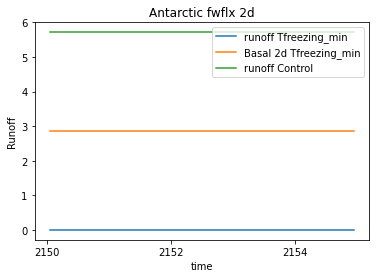

In [11]:
runoff_Tfreezing_min.plot(label='runoff Tfreezing_min')
basal_Tfreezing_min_2d.plot(label='Basal 2d Tfreezing_min')
runoff_con.plot(label='runoff Control')
plt.title('Antarctic fwflx 2d')
plt.ylabel('Runoff')
plt.legend();

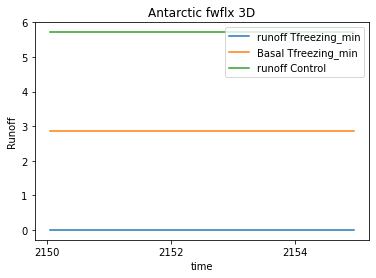

In [12]:
#runoff_Tfreezing_insituS.plot(label='Tfreezing_insituS')
#runoff_Tfreezing_zeroS.plot(label='Tfreezing_zeroS')
runoff_Tfreezing_min.plot(label='runoff Tfreezing_min')
basal_Tfreezing_min.plot(label='Basal Tfreezing_min')
runoff_con.plot(label='runoff Control')
plt.title('Antarctic fwflx 3D')
plt.ylabel('Runoff')
plt.legend();

Text(0.5, 1.0, 'Basal Tfreezing_min / runoff Control')

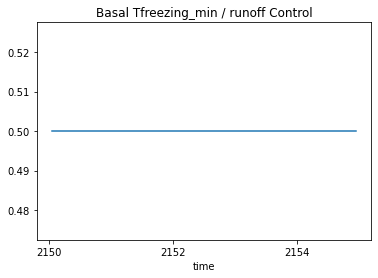

In [13]:
(basal_Tfreezing_min/runoff_con).plot(label='Basal Tfreezing_min / runoff Control')
plt.title('Basal Tfreezing_min / runoff Control')

Text(0.5, 1.0, 'River Tfreezing_min / runoff Control')

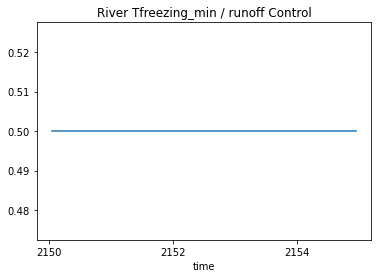

In [14]:
(river_Tfreezing_min/runoff_con).plot(label='River Tfreezing_min / runoff Control')
plt.title('River Tfreezing_min / runoff Control')

In [15]:
# Check the ratio betwee basal and runoff on the x dimension

#Import runoff
runoff_con_x = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con_x = runoff_con_x.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con_x = runoff_con_x.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_x = cc.querying.getvar(Tfreezing_min, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_x = basal_Tfreezing_min_x.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_x = basal_Tfreezing_min_x[:,:,:,:].sum('yt_ocean_sub01').sum('st_ocean').load()

2022-08-17 10:59:59,987 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-17 11:00:04,181 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-17 11:00:06,409 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-08-17 11:00:08,849 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-08-17 11:00:11,633 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-08-17 11:01:09,246 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [16]:
ratio_x = basal_Tfreezing_min_x * 0
for nt in range(basal_Tfreezing_min_x.shape[0]):
    for nx in range(basal_Tfreezing_min_x.shape[1]):
        if runoff_con_x[nt,nx] != 0:
            ratio_x[nt,nx] = basal_Tfreezing_min_x[nt,nx]/runoff_con_x[nt,nx]/0.5
        if basal_Tfreezing_min_x[nt,nx] == 0 and runoff_con_x[nt,nx] == 0: 
            ratio_x[nt,nx]=1


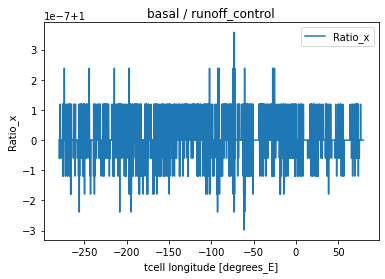

In [17]:
ratio_x[-1,:].plot(label='Ratio_x')
plt.title('basal / runoff_control')
plt.ylabel('Ratio_x')
plt.legend();

In [18]:
# Timeseries of depth integrated salinity on shelf:

In [19]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice)

In [20]:
# thickness area for depth averaging (not time varying):

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [21]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask

#area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

volume = area_t*thickness
volume_sum = volume.sum()

In [22]:
salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_con = salt_con*shelf_mask
# area and depth averaging on the shelf:
salt_con = (salt_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_con = salt_con.load()                         

#salt_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_insituS = salt_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
## shelf masking:
#salt_Tfreezing_insituS = salt_Tfreezing_insituS*shelf_mask
## area and depth averaging on the shelf:
#salt_Tfreezing_insituS = (salt_Tfreezing_insituS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
#salt_Tfreezing_insituS = salt_Tfreezing_insituS.load()                         

#salt_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
## shelf masking:
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS*shelf_mask
## area and depth averaging on the shelf:
#salt_Tfreezing_zeroS = (salt_Tfreezing_zeroS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.load()                         

salt_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min = salt_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_Tfreezing_min = salt_Tfreezing_min*shelf_mask
# area and depth averaging on the shelf:
salt_Tfreezing_min = (salt_Tfreezing_min*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_Tfreezing_min = salt_Tfreezing_min.load()                         

Text(0.5, 1.0, 'Depth average salinity on the shelf')

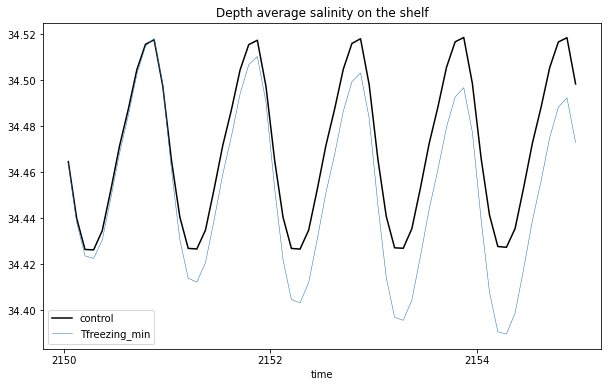

In [23]:
plt.figure(figsize=(10,6))

salt_con.plot(label='control',color='k')
#salt_Tfreezing_insituS.plot(label='Tfreezing_insituS',linewidth=2)
#salt_Tfreezing_zeroS.plot(label='Tfreezing_zeroS',linestyle='--')
salt_Tfreezing_min.plot(label='Tfreezing_min',linewidth=0.5)
plt.legend()
plt.title('Depth average salinity on the shelf')

In [24]:
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
temp_con = temp_con*shelf_mask
# area and depth averaging on the shelf:
temp_con = (temp_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_con = temp_con.load()                         

#temp_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_insituS = temp_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
## shelf masking:
#temp_Tfreezing_insituS = temp_Tfreezing_insituS*shelf_mask
## area and depth averaging on the shelf:
#temp_Tfreezing_insituS = (temp_Tfreezing_insituS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
#temp_Tfreezing_insituS = temp_Tfreezing_insituS.load()                         

#temp_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
## shelf masking:
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS*shelf_mask
## area and depth averaging on the shelf:
#temp_Tfreezing_zeroS = (temp_Tfreezing_zeroS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.load()                         

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
temp_Tfreezing_min = temp_Tfreezing_min*shelf_mask
# area and depth averaging on the shelf:
temp_Tfreezing_min = (temp_Tfreezing_min*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_Tfreezing_min = temp_Tfreezing_min.load()    

Text(0.5, 1.0, 'Depth average temperature on the shelf')

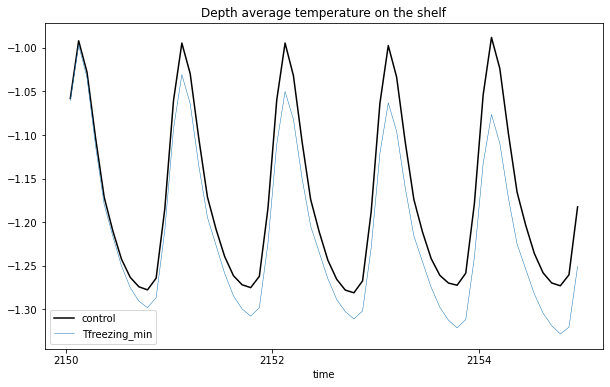

In [25]:
plt.figure(figsize=(10,6))

temp_con.plot(label='control',color='k')
#temp_Tfreezing_insituS.plot(label='Tfreezing_insituS',linewidth=2)
#temp_Tfreezing_zeroS.plot(label='Tfreezing_zeroS',linestyle='--')
temp_Tfreezing_min.plot(label='Tfreezing_min',linewidth=0.5)
plt.legend()
plt.title('Depth average temperature on the shelf')

In [36]:
# Heat flux from runoff

In [ ]:
###Check runoff flux
#Import runoff
hflux_runoff_con = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_runoff_con = hflux_runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_runoff_con_x = hflux_runoff_con.sum('yt_ocean').load()
hflux_runoff_con_x_avet = hflux_runoff_con.sum('yt_ocean')
hflux_runoff_con_x_avet = hflux_runoff_con_x_avet.mean('time').load()
hflux_runoff_con = hflux_runoff_con.sum('yt_ocean').sum('xt_ocean').load()

In [8]:
hflux_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp_basalmix', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_Tfreezing_min = hflux_Tfreezing_min.sel(time=slice(start_time,end_time))
hflux_Tfreezing_min_x = hflux_Tfreezing_min.sum('yt_ocean_sub01').sum('st_ocean')
hflux_Tfreezing_min_x_avet = hflux_Tfreezing_min_x.mean('time').load()
hflux_Tfreezing_min = hflux_Tfreezing_min_x.sum('xt_ocean_sub01').load()
hflux_Tfreezing_min_x = hflux_Tfreezing_min_x.load()

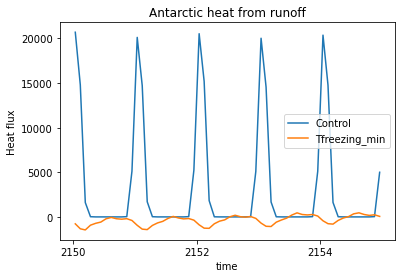

In [9]:
hflux_runoff_con.plot(label='Control')
hflux_Tfreezing_min.plot(label='Tfreezing_min')
#surface_salt_Tfreezing_min_sum.plot(label='Tfreezing_min')
#surface_salt_con_sum.plot(label='Control')
plt.title('Antarctic heat from runoff')
plt.ylabel('Heat flux')
plt.legend();

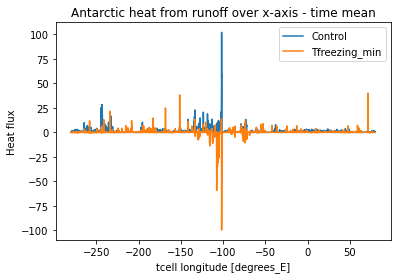

In [10]:
hflux_runoff_con_x_avet.plot(label='Control')
hflux_Tfreezing_min_x_avet.plot(label='Tfreezing_min')
plt.title('Antarctic heat from runoff over x-axis - time mean')
plt.ylabel('Heat flux')
plt.legend();

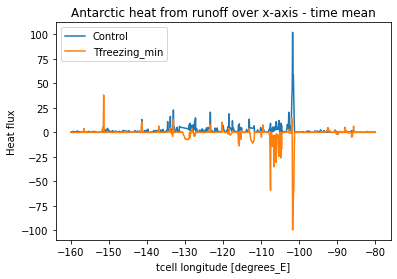

In [11]:
hflux_runoff_con_x_avet[1200:2000].plot(label='Control')
hflux_Tfreezing_min_x_avet[1200:2000].plot(label='Tfreezing_min')
plt.title('Antarctic heat from runoff over x-axis - time mean')
plt.ylabel('Heat flux')
plt.legend();

In [21]:
hflux_Tfreezing_min_x['xt_ocean_sub01']

<xarray.DataArray 'xt_ocean_sub01' (xt_ocean_sub01: 3600)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Coordinates:
  * xt_ocean_sub01  (xt_ocean_sub01) float64 -279.9 -279.8 ... 79.85 79.95
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X

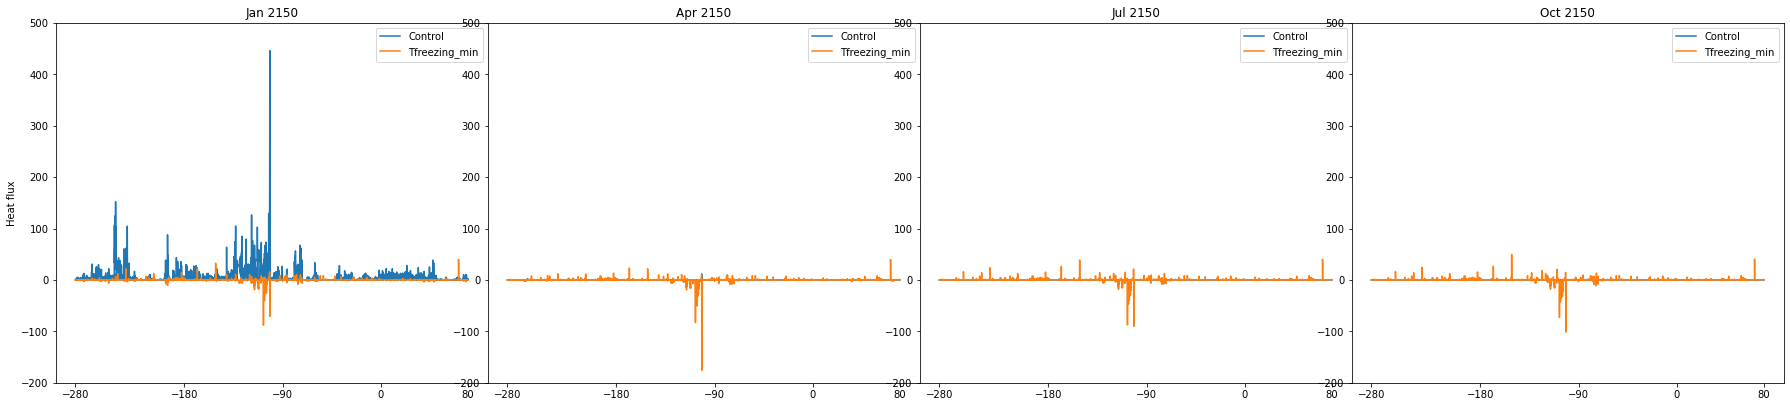

In [51]:
fig  = plt.figure(1, figsize = (20,5))

tt=0
ax = fig.add_axes([0.0, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Jan 2150')
plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=3
ax = fig.add_axes([0.3, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Apr 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=6
ax = fig.add_axes([0.6, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Jul 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=9
ax = fig.add_axes([0.9, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Oct 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

In [40]:
# Bottom analysis

## Temp

In [26]:
start_time='2154-01-01'
end_time='2155-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

#temp_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_insituS = temp_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#temp_Tfreezing_insituS = temp_Tfreezing_insituS.mean('time')

#temp_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.mean('time')

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min = temp_Tfreezing_min.mean('time')

In [29]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

#bottom_temp_Tfreezing_insituS = temp_Tfreezing_insituS.where(depth_array.st_ocean >= max_depth)
#bottom_temp_Tfreezing_insituS = bottom_temp_Tfreezing_insituS.sum(dim = 'st_ocean')
#bottom_temp_Tfreezing_insituS = bottom_temp_Tfreezing_insituS.load()

#bottom_temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.where(depth_array.st_ocean >= max_depth)
#bottom_temp_Tfreezing_zeroS = bottom_temp_Tfreezing_zeroS.sum(dim = 'st_ocean')
#bottom_temp_Tfreezing_zeroS = bottom_temp_Tfreezing_zeroS.load()

bottom_temp_Tfreezing_min = temp_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.load()

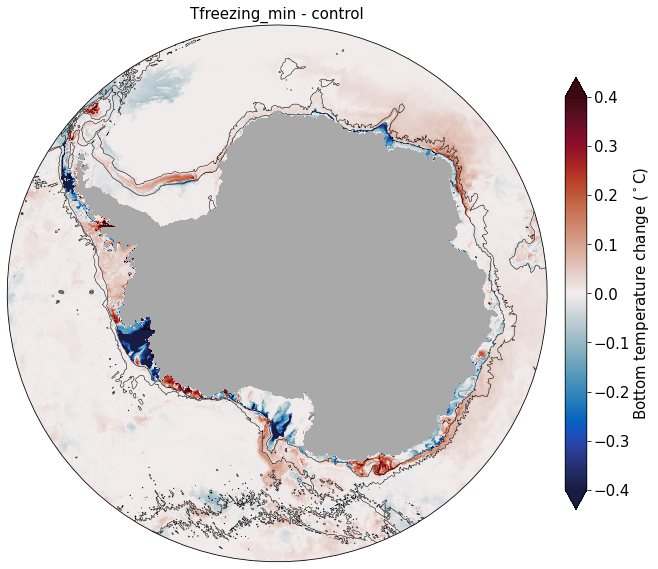

In [30]:
scale_max = .4

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
# plot:
#cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_insituS-bottom_temp_con, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_zeroS-bottom_temp_con, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [45]:
## Salt

In [31]:
start_time='2154-01-01'
end_time='2155-01-01'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_con = salt_con.mean('time')


#salt_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_insituS = salt_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#salt_Tfreezing_insituS = salt_Tfreezing_insituS.mean('time')

#salt_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.mean('time')

salt_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min = salt_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_Tfreezing_min = salt_Tfreezing_min.mean('time')

In [32]:
# select out bottom values:

depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

#bottom_salt_Tfreezing_insituS = salt_Tfreezing_insituS.where(depth_array.st_ocean >= max_depth)
#bottom_salt_Tfreezing_insituS = bottom_salt_Tfreezing_insituS.sum(dim = 'st_ocean')
#bottom_salt_Tfreezing_insituS = bottom_salt_Tfreezing_insituS.load()

#bottom_salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.where(depth_array.st_ocean >= max_depth)
#bottom_salt_Tfreezing_zeroS = bottom_salt_Tfreezing_zeroS.sum(dim = 'st_ocean')
#bottom_salt_Tfreezing_zeroS = bottom_salt_Tfreezing_zeroS.load()

bottom_salt_Tfreezing_min = salt_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_salt_Tfreezing_min = bottom_salt_Tfreezing_min.sum(dim = 'st_ocean')
bottom_salt_Tfreezing_min = bottom_salt_Tfreezing_min.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

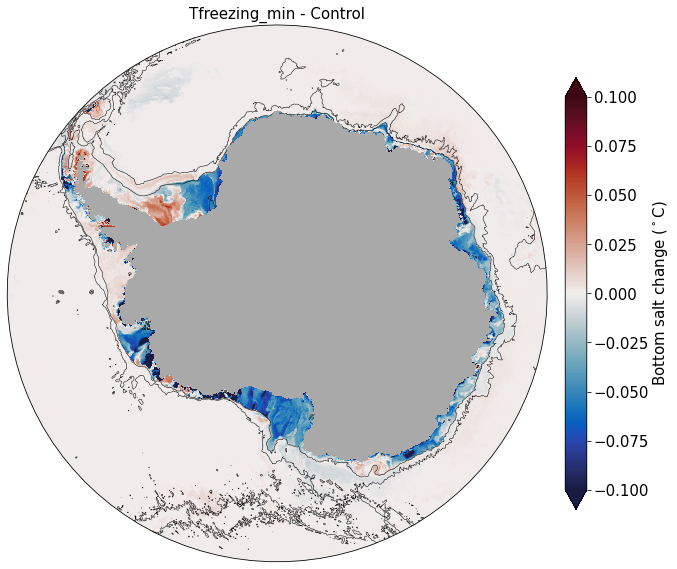

In [33]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
# plot:
#cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_insituS-bottom_salt_con, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
# plot:
#cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_zeroS-bottom_salt_con, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_min-bottom_salt_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salt change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [49]:
# Surface

In [38]:
start_time='2154-01-01'
end_time='2155-01-01'

#Import surface_temp
surface_temp_con = cc.querying.getvar(control, 'surface_temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_con = surface_temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_con_sum = surface_temp_con.sum('yt_ocean').sum('xt_ocean').load()
surface_temp_con_ave = surface_temp_con.mean('time')

#surface_temp_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) -273.15
#surface_temp_Tfreezing_insituS = surface_temp_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#surface_temp_Tfreezing_insituS_sum = surface_temp_Tfreezing_insituS.sum('yt_ocean').sum('xt_ocean').load()
#surface_temp_Tfreezing_insituS_ave = surface_temp_Tfreezing_insituS.mean('time')

#surface_temp_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#surface_temp_Tfreezing_zeroS = surface_temp_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#surface_temp_Tfreezing_zeroS_sum = surface_temp_Tfreezing_zeroS.sum('yt_ocean').sum('xt_ocean').load()
#surface_temp_Tfreezing_zeroS_ave = surface_temp_Tfreezing_zeroS.mean('time')

surface_temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_Tfreezing_min = surface_temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_Tfreezing_min_sum = surface_temp_Tfreezing_min.sum('yt_ocean').sum('xt_ocean').load()
surface_temp_Tfreezing_min_ave = surface_temp_Tfreezing_min.mean('time')

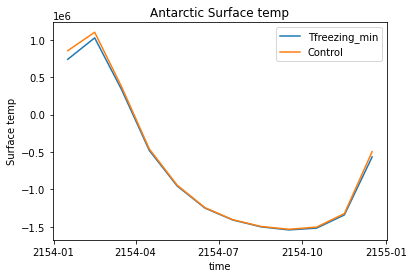

In [39]:
#surface_temp_Tfreezing_insituS_sum.plot(label='Tfreezing_insituS')
#surface_temp_Tfreezing_zeroS_sum.plot(label='Tfreezing_zeroS')
surface_temp_Tfreezing_min_sum.plot(label='Tfreezing_min')
surface_temp_con_sum.plot(label='Control')
plt.title('Antarctic Surface temp')
plt.ylabel('Surface temp')
plt.legend();

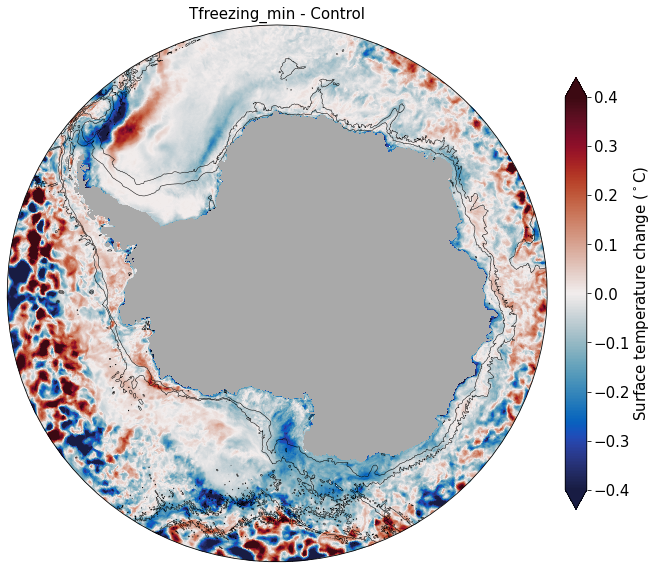

In [41]:
scale_max = .4

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(surface_temp_con_ave.xt_ocean, surface_temp_con_ave.yt_ocean, surface_temp_Tfreezing_insituS_ave-surface_temp_con_ave, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
# plot:
#cf = ax.pcolormesh(surface_temp_con_ave.xt_ocean, surface_temp_con_ave.yt_ocean, surface_temp_Tfreezing_zeroS_ave-surface_temp_con_ave, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_temp_con_ave.xt_ocean, surface_temp_con_ave.yt_ocean, surface_temp_Tfreezing_min_ave-surface_temp_con_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [42]:
start_time='2154-01-01'
end_time='2155-01-01'

#Import surface_salt
surface_salt_con = cc.querying.getvar(control, 'surface_salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
surface_salt_con = surface_salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_con_sum = surface_salt_con.sum('yt_ocean').sum('xt_ocean').load()
surface_salt_con_ave = surface_salt_con.mean('time')

#surface_salt_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#surface_salt_Tfreezing_insituS = surface_salt_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#surface_salt_Tfreezing_insituS_sum = surface_salt_Tfreezing_insituS.sum('yt_ocean').sum('xt_ocean').load()
#surface_salt_Tfreezing_insituS_ave = surface_salt_Tfreezing_insituS.mean('time')

#surface_salt_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#surface_salt_Tfreezing_zeroS = surface_salt_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#surface_salt_Tfreezing_zeroS_sum = surface_salt_Tfreezing_zeroS.sum('yt_ocean').sum('xt_ocean').load()
#surface_salt_Tfreezing_zeroS_ave = surface_salt_Tfreezing_zeroS.mean('time')

surface_salt_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
surface_salt_Tfreezing_min = surface_salt_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_Tfreezing_min_sum = surface_salt_Tfreezing_min.sum('yt_ocean').sum('xt_ocean').load()
surface_salt_Tfreezing_min_ave = surface_salt_Tfreezing_min.mean('time')

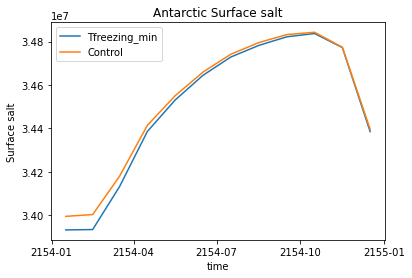

In [43]:
#surface_salt_Tfreezing_insituS_sum.plot(label='Tfreezing_insituS')
#surface_salt_Tfreezing_zeroS_sum.plot(label='Tfreezing_zeroS')
surface_salt_Tfreezing_min_sum.plot(label='Tfreezing_min')
surface_salt_con_sum.plot(label='Control')
plt.title('Antarctic Surface salt')
plt.ylabel('Surface salt')
plt.legend();

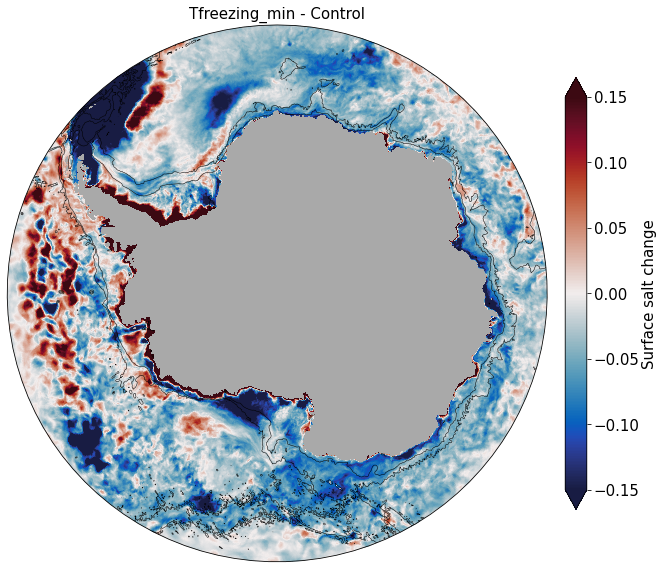

In [44]:
scale_max = .15

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(surface_salt_con_ave.xt_ocean, surface_salt_con_ave.yt_ocean, surface_salt_Tfreezing_insituS_ave-surface_salt_con_ave, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
# plot:
#cf = ax.pcolormesh(surface_salt_con_ave.xt_ocean, surface_salt_con_ave.yt_ocean, surface_salt_Tfreezing_zeroS_ave-surface_salt_con_ave, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_salt_con_ave.xt_ocean, surface_salt_con_ave.yt_ocean, surface_salt_Tfreezing_min_ave-surface_salt_con_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface salt change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [49]:
#Sea ice

In [8]:
start_time='2151-01-01'
end_time='2152-01-01'
lat_slice  = slice(-80,-59)

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

#Import seaice
hi_con = cc.querying.getvar(control, 'hi_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_con = cc.querying.getvar(control, 'aice_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)


hi_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

In [9]:
    # Rename coordinates
    # t-grid
    aice_con.coords['ni'] = area_t['xt_ocean'].values
    aice_con.coords['nj'] = area_t['yt_ocean'].values
    aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    hi_con.coords['ni'] = area_t['xt_ocean'].values
    hi_con.coords['nj'] = area_t['yt_ocean'].values
    hi_con = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    
    aice_Tfreezing_min.coords['ni'] = area_t['xt_ocean'].values
    aice_Tfreezing_min.coords['nj'] = area_t['yt_ocean'].values
    aice_Tfreezing_min = aice_Tfreezing_min.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    hi_Tfreezing_min.coords['ni'] = area_t['xt_ocean'].values
    hi_Tfreezing_min.coords['nj'] = area_t['yt_ocean'].values
    hi_Tfreezing_min = hi_Tfreezing_min.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [10]:
hi_con = hi_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_con = aice_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

hi_Tfreezing_min = hi_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_Tfreezing_min = aice_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [11]:
hi_con_avet = hi_con.mean('time').load()
aice_con_avet = aice_con.mean('time').load()

hi_Tfreezing_min_avet = hi_Tfreezing_min.mean('time').load()
aice_Tfreezing_min_avet = aice_Tfreezing_min.mean('time').load()

In [12]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con = aice_con_avet * area_t * hi_con_avet * 1e-9
#vi_con = vi_con.rename('vi')

vi_Tfreezing_min = aice_Tfreezing_min_avet * area_t * hi_Tfreezing_min_avet * 1e-9
#vi_Tfreezing_min = vi_Tfreezing_min.rename('vi')


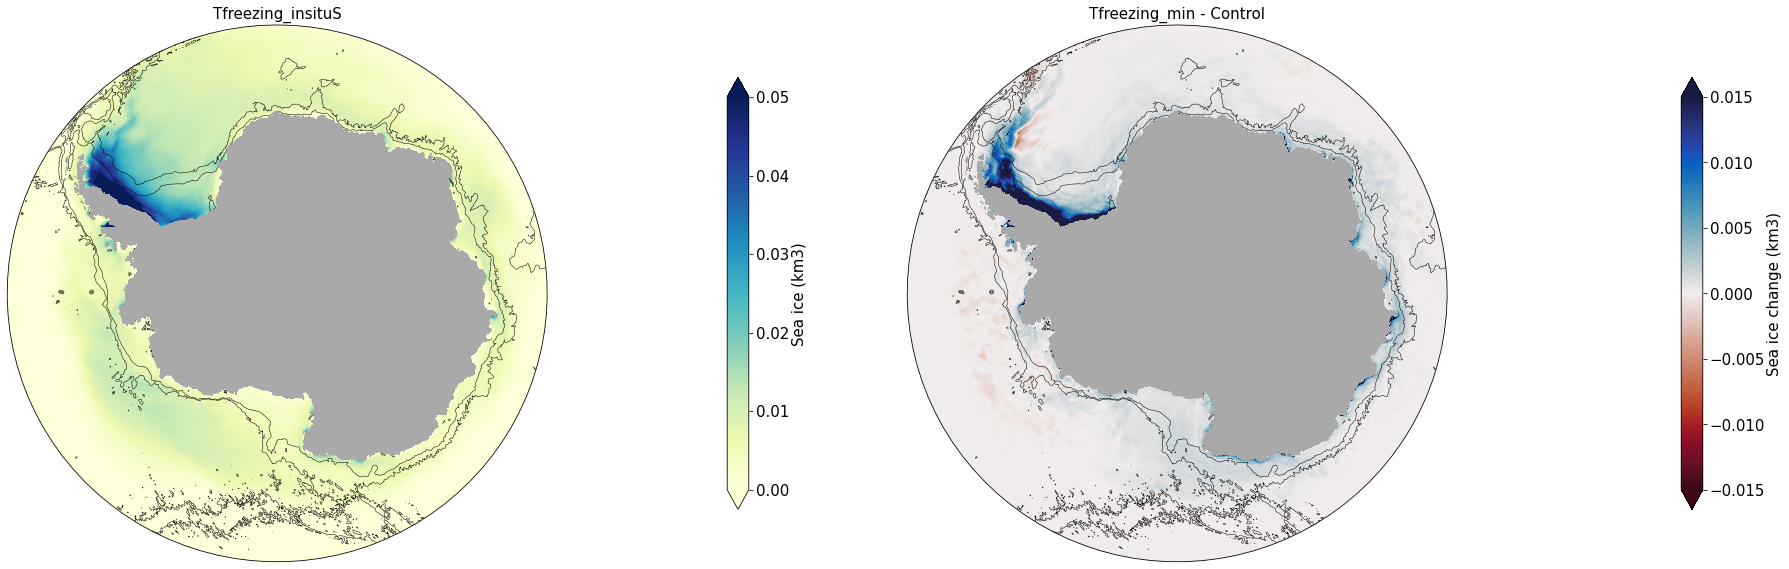

In [13]:
scale_max = .015

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)


# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_con, vmin=0,vmax=0.05,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.4, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min
ax = fig.add_axes([0.5, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_Tfreezing_min-vi_con, norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [55]:
#Other stuff

In [9]:
import numpy as np
from netCDF4 import Dataset as nc

nc_calv_file = "/g/data/e14/pc5520/calving/licalvf.nc"
nc_runoff_file="/g/data/e14/pc5520/calving/RYF.runoff_all.1990_1991.nc"
ncfile_calv = nc(nc_calv_file,'r')
ncfile_runoff = nc(nc_runoff_file,'r')
calving = ncfile_calv.variables['licalvf'][0,:,:]
friver  = ncfile_runoff.variables['friver'][0,:,:]

calving_sumy = calving[0,:]*0
friver_sumy  = friver[0,:]*0
xxx = friver[0,:]*0

In [10]:

for xx in range(friver[:,:].shape[1]):
    xxx[xx] = xx
    friver_sumy[xx] = friver[:,xx].sum()
    calving_sumy[xx] = calving[:,xx].sum()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


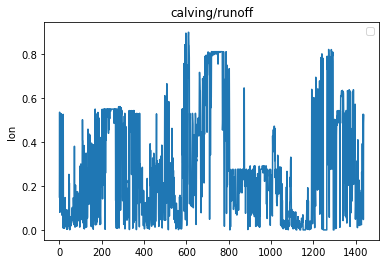

In [11]:
plt.plot(xxx,calving_sumy/friver_sumy)
plt.title('calving/runoff')
plt.ylabel('lon')
plt.legend();

In [16]:
(calving_sumy/friver_sumy).mean()

0.2860152774386936